In [39]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import MDS
from numpy import linalg as LA
import matplotlib.pyplot as plt

#Implementation of the Aitchison distance
def aitchison(u, v):
    log_u_v = np.log(u+1e-5)-np.log(v+1e-5)
    dist = LA.norm(log_u_v - np.mean(log_u_v))
    return dist

def Compute_Amatrix(adata):
    batch_size_features= adata.X.shape[0]
    Mw_matrix = np.zeros((batch_size_features,batch_size_features)) #w distance matrix
    for col_i in range(0,batch_size_features):
        for col_j in range(col_i,batch_size_features):
            Mw_matrix[col_i,col_j] = aitchison(adata.X[col_i,:],adata.X[col_j,:])
    Mw_matrix= Mw_matrix+Mw_matrix.T-np.diag(np.diag(Mw_matrix))
    np.savetxt('mymethod/MA_matrix.csv', Mw_matrix, delimiter=',')
    return Mw_matrix

def evaluate_Kmeas_clustering(adata,d_matrix,k):
    mds = MDS(n_components=k,dissimilarity='precomputed',\
          random_state=0, normalized_stress='auto')
    X_transform = mds.fit_transform(d_matrix)
    kmeans_model = KMeans(n_clusters = 4,n_init='auto')
    kmeans_model.fit(X_transform)
    adata.obs['kmeans'] = kmeans_model.labels_ 
    adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)
    #rand_index = jaccard_score(adata.obs['Cell_Type'], adata.obs['kmeans'], average=None)
    rand_index = adjusted_rand_score(labels_true = adata.obs['Cell_Type'], labels_pred = adata.obs['kmeans'])
    return rand_index

CPU times: user 21h 54min 47s, sys: 1d 18h 6min 44s, total: 2d 16h 1min 31s
Wall time: 8h 9min 33s


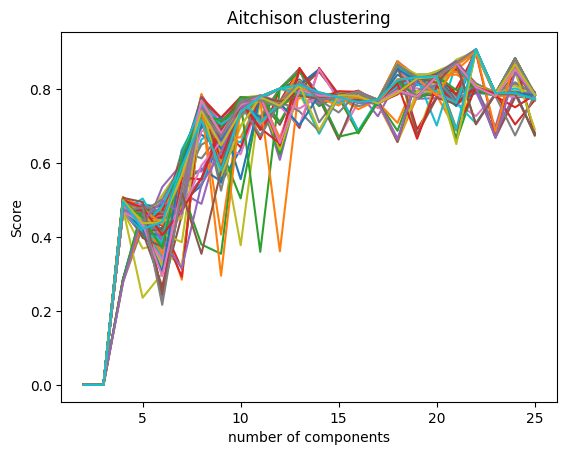

In [2]:
%%time
adata = sc.read('mymethod/cells_raw.h5ad')
sc.pp.normalize_total(adata, target_sum=1e6) # normalize
MA_matrix = Compute_Amatrix(adata)
n_components=25
n_c=np.linspace(2,n_components,n_components-1)
trials=100
scores=np.zeros((trials,len(n_c)))
for t in range(0,trials):
    for k in range(2,n_components-1):
        scores[t,k]=evaluate_Kmeas_clustering(adata,MA_matrix,k)
np.savetxt('mymethod/MA_trials_scores100.csv', scores, delimiter=',')
for t in range(0,trials):
    plt.plot(n_c,scores[t,:])
plt.xlabel("number of components")
plt.ylabel("Score")
plt.title("Aitchison clustering")
plt.savefig("Ascores.svg")

CPU times: user 235 ms, sys: 144 ms, total: 379 ms
Wall time: 162 ms


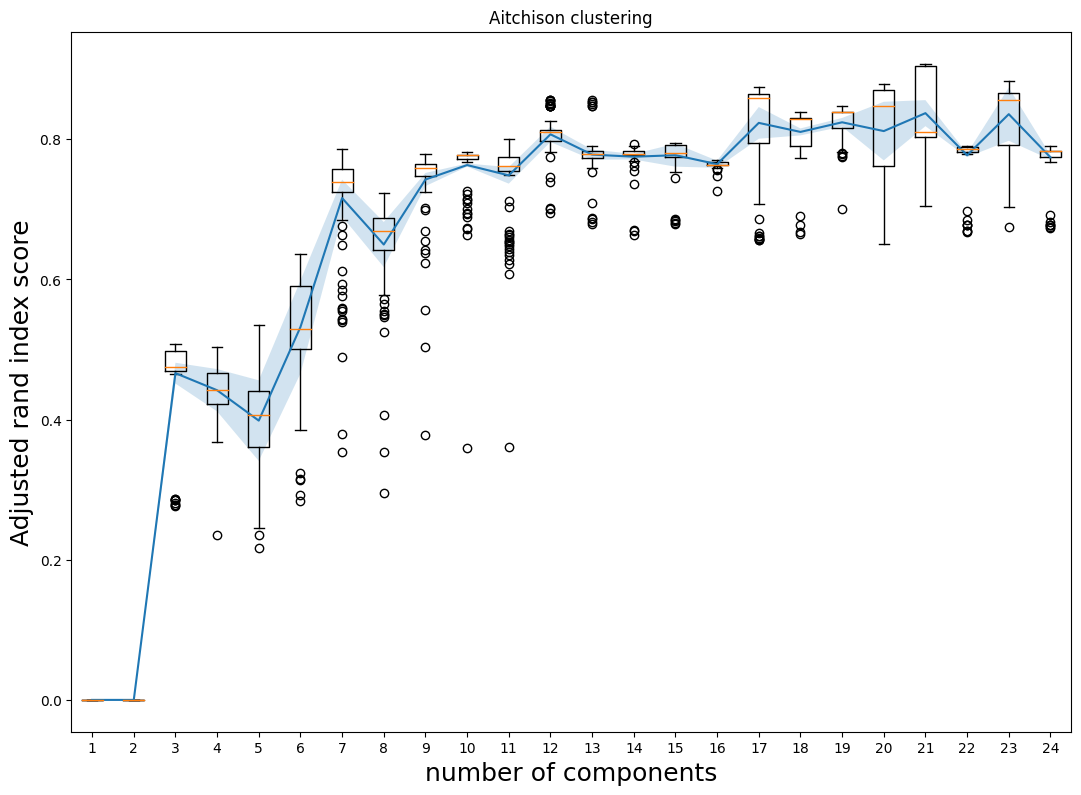

In [45]:
%%time
from statsmodels import robust
scores=np.loadtxt('mymethod/MA_trials_scores100.csv', delimiter=',')
n_components=25
mean_score=np.mean(scores,0)
mad_scores=robust.mad(scores, axis=0)
x=np.linspace(1,n_components,n_components)
fig = plt.figure(figsize =(10, 7)) 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(scores)
plt.plot(x[0:-1],mean_score)
ax.fill_between(x[0:-1],mean_score - mad_scores, mean_score + mad_scores, alpha=0.2)
plt.xlabel("number of components", fontsize=18)
plt.ylabel("Adjusted rand index score", fontsize=18)
plt.title("Aitchison clustering")
plt.savefig("Ascoresstats.svg")